In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
test = pd.read_csv('data/test.csv')
train = pd.read_csv('data/train.csv')

# Indicator for missing values in rows
train['missing_indicator'] = train.isnull().any(axis=1).astype(int)

count    8990.000000
mean        0.000051
std         0.010568
min        -0.040582
25%        -0.004759
50%         0.000252
75%         0.005479
max         0.040551
Name: market_forward_excess_returns, dtype: float64

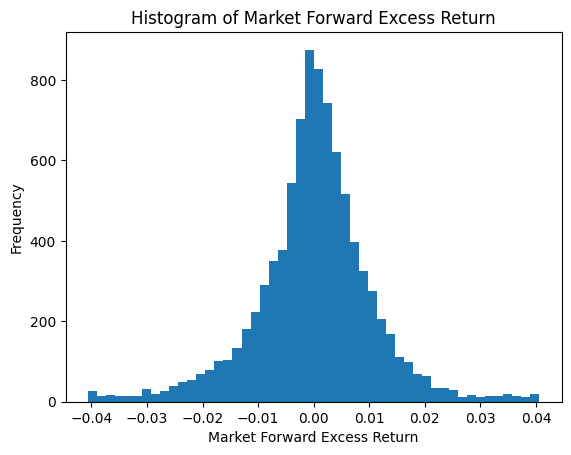

In [3]:
display(train['market_forward_excess_returns'].describe())

plt.hist(train['market_forward_excess_returns'], bins=50)
plt.title('Histogram of Market Forward Excess Return')
plt.xlabel('Market Forward Excess Return')
plt.ylabel('Frequency')
plt.show()

### Train has many cols with missing data
- They are for earlier dates - potentially moving averages or similar?
- The last 22% of data (2021 rows) have full data

Option 1:
- Impute using various methods
- Backfill, mean, median and KNN

Option 2:
- Don't inpute and use methods which handle NaN values
- E.g. xgboost and other tree methods

Plan:
- Try both option 1 (with the various imputers) and option 2
- Test on first 80% of data by date_id, test on 80-90% percentile of date_id
- Test on first 90% of data by date_id, test on remaining 10%
- Compare out of sample performance metrics, with R^2 being more relevant here

Additional thoughts:
- Start with simple models then experiment further - however tree based models are good to start for feature importance
- Consider weighting the data used for fitting by a time decay (more recent data more useful) - only after fitting with no time decay
- Look at feature reduction methods

In [4]:
import pandas as pd
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler

# --- 1. Backfill (future → past) ---
train_backfill = train.copy()
train_backfill = train_backfill.bfill().ffill()   # ffill after bfill to handle edges


# --- 2. Global Mean Imputation ---
train_mean_impute = train.copy()
train_mean_impute = train_mean_impute.fillna(train_mean_impute.mean())


# --- 3. Global Median Imputation ---
train_median_impute = train.copy()
train_median_impute = train_median_impute.fillna(train_median_impute.median())

# --- 4. KNN Imputation with Scaling ---
# Identify numeric columns excluding specific ones
numeric_cols = train.select_dtypes(include=["number"]).columns.tolist()
cols_exclude = ["date_id", "forward_returns", "risk_free_rate", "market_forward_excess_returns", "missing_indicator"] 
cols_for_knn = [c for c in numeric_cols if c not in cols_exclude]

# Copy for reconstruction
train_knn_impute = train.copy()

# Extract only the columns that should be imputed
X = train[cols_for_knn].copy()

# --- Scaling ---
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# --- KNN Imputation ---
knn = KNNImputer(n_neighbors=2)
X_scaled_imputed = knn.fit_transform(X_scaled)

# --- Inverse scaling ---
X_imputed = scaler.inverse_transform(X_scaled_imputed)

# --- Reassemble ---
train_knn_impute[cols_for_knn] = X_imputed

# --- Rounding issue of Binary Columns ---
binary_cols = [col for col in cols_for_knn if col.startswith("D")]
for col in binary_cols:
    train_knn_impute[col] = train_knn_impute[col].round().astype(int)

- When training on the imputed data to test on the non imputed data, backfill is best as many features are rolling averages
- This isn't too informative however, as we use the test set for training the imputed values

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# --- Helper: function to add target & split, train RF, and evaluate ---
def evaluate_imputer_version(df_imputed, imputer_name):
    df = df_imputed.copy()

    # Ensure sorted by time
    df = df.sort_values("date_id")

    # Create target: next day's market_forward_excess_returns
    df["lagged_market_forward_excess_returns"] = df["market_forward_excess_returns"].shift(-1)

    # Drop last row (no target)
    df = df.dropna(subset=["lagged_market_forward_excess_returns"])

    # Columns to exclude from features
    base_exclude = [
        "date_id",
        "forwards_returns",         
        "risk_free_rate",
        "market_forward_excess_returns",
        "missing_indicator",
        "lagged_market_forward_excess_returns",   # target
    ]

    # Use only numeric columns as features (avoids encoding)
    numeric_cols = df.select_dtypes(include=["number"]).columns.tolist()
    exclude_cols = [c for c in base_exclude if c in numeric_cols]
    feature_cols = [c for c in numeric_cols if c not in exclude_cols]

    # Train on rows that originally had missing values; test on rows with no missing values
    train_mask = df["missing_indicator"] == 1
    test_mask  = df["missing_indicator"] == 0

    X_train = df.loc[train_mask, feature_cols]
    y_train = df.loc[train_mask, "lagged_market_forward_excess_returns"]

    X_test  = df.loc[test_mask, feature_cols]
    y_test  = df.loc[test_mask, "lagged_market_forward_excess_returns"]

    # Simple, reasonably robust model with minimal tuning
    model = RandomForestRegressor(
        n_estimators=300,
        max_depth=None,
        min_samples_leaf=5,
        random_state=42,
        n_jobs=-1,
    )

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Metrics (focus on R² but also MAE/RMSE)
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    return {
        "imputer": imputer_name,
        "R2": r2,
        "MAE": mae,
        "RMSE": rmse,
        "model": model,
        "feature_cols": feature_cols,
    }


# --- 2. Run for each imputed dataset ---

imputed_versions = {
    "backfill": train_backfill,
    "mean": train_mean_impute,
    "median": train_median_impute,
    "knn": train_knn_impute,
}

results = []
for name, df_imp in imputed_versions.items():
    print(f"Evaluating imputer: {name}")
    res = evaluate_imputer_version(df_imp, name)
    results.append(res)

# --- 3. Summarise metrics in a DataFrame ---

metrics_df = pd.DataFrame(
    [{"imputer": r["imputer"], "R2": r["R2"], "MAE": r["MAE"], "RMSE": r["RMSE"]} for r in results]
).sort_values("R2", ascending=False)

print(metrics_df)


- Here we train and test on the imputed set only, so more informative
- KNN best, so will be the imputation method used

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np

def evaluate_imputer_missing_only(df_imputed, imputer_name):
    df = df_imputed.copy().sort_values("date_id")

    # Target: next-day excess return
    df["lagged_market_forward_excess_returns"] = (
        df["market_forward_excess_returns"].shift(-1)
    )

    df = df.dropna(subset=["lagged_market_forward_excess_returns"])

    # Only rows that were originally missing
    df_sub = df[df["missing_indicator"] == 1]

    # Time split INSIDE missing region
    split = int(len(df_sub) * 0.8)
    train_df = df_sub.iloc[:split]
    test_df  = df_sub.iloc[split:]

    # Feature exclusion
    base_exclude = [
        "date_id",
        "forward_returns",
        "risk_free_rate",
        "market_forward_excess_returns",
        "missing_indicator",
        "lagged_market_forward_excess_returns",
    ]

    numeric_cols = df.select_dtypes(include=["number"]).columns.tolist()
    feature_cols = [c for c in numeric_cols if c not in base_exclude]

    X_train = train_df[feature_cols]
    y_train = train_df["lagged_market_forward_excess_returns"]

    X_test  = test_df[feature_cols]
    y_test  = test_df["lagged_market_forward_excess_returns"]

    model = RandomForestRegressor(
        n_estimators=300,
        min_samples_leaf=5,
        random_state=42,
        n_jobs=-1,
    )

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    return {
        "imputer": imputer_name,
        "R2": r2_score(y_test, y_pred),
        "MAE": mean_absolute_error(y_test, y_pred),
        "RMSE": np.sqrt(mean_squared_error(y_test, y_pred)),
    }

results_missing_only = []

for name, df_imp in imputed_versions.items():
    print(f"Evaluating (missing-only regime): {name}")
    res = evaluate_imputer_missing_only(df_imp, name)
    results_missing_only.append(res)

missing_only_df = pd.DataFrame(results_missing_only).sort_values("R2", ascending=False)
print(missing_only_df)

- Next two blocks to find best KNN tuning
- The first one finds that the best KNN with 2-5 neighbours 
- The second code block now uses multiple time based splits to further indentify best KNN method
- K=2 is chosen

In [ ]:
# --- Function: given an imputed df, evaluate on missing-only regime (stationary test) ---
def evaluate_on_missing_only(df_imputed, label):
    df = df_imputed.copy().sort_values("date_id")

    # Target: next-day market_forward_excess_returns
    df["lagged_market_forward_excess_returns"] = df["market_forward_excess_returns"].shift(-1)
    df = df.dropna(subset=["lagged_market_forward_excess_returns"])

    # Restrict to rows that originally had missing data
    df_sub = df[df["missing_indicator"] == 1].copy()

    # Time split inside missing-only region
    split = int(len(df_sub) * 0.8)
    train_df = df_sub.iloc[:split]
    test_df  = df_sub.iloc[split:]

    # Exclude non-feature columns
    base_exclude = [
        "date_id",
        "forward_returns",
        "risk_free_rate",
        "market_forward_excess_returns",
        "missing_indicator",
        "lagged_market_forward_excess_returns",
    ]

    numeric_cols = df.select_dtypes(include=["number"]).columns.tolist()
    feature_cols = [c for c in numeric_cols if c not in base_exclude]

    X_train = train_df[feature_cols]
    y_train = train_df["lagged_market_forward_excess_returns"]

    X_test  = test_df[feature_cols]
    y_test  = test_df["lagged_market_forward_excess_returns"]

    # Simple, stable model
    model = RandomForestRegressor(
        n_estimators=300,
        min_samples_leaf=5,
        random_state=42,
        n_jobs=-1,
    )

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    return {
        "knn_setting": label,
        "R2": r2,
        "MAE": mae,
        "RMSE": rmse,
    }


k_values = [1, 2, 3, 4, 5, 7, 10, 15, 25]

weight_options = ["uniform", "distance"]

results_knn_refined = []

for weights in weight_options:
    for k in k_values:
        print(f"KNN: k={k}, weights={weights}")

        train_knn_impute_k = train.copy()
        X = train[cols_for_knn].copy()

        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)

        knn = KNNImputer(n_neighbors=k, weights=weights)
        X_scaled_imputed = knn.fit_transform(X_scaled)

        X_imputed = scaler.inverse_transform(X_scaled_imputed)
        train_knn_impute_k[cols_for_knn] = X_imputed

        binary_cols = [c for c in cols_for_knn if c.startswith("D")]
        for col in binary_cols:
            train_knn_impute_k[col] = train_knn_impute_k[col].round().astype(int)

        res = evaluate_on_missing_only(
            train_knn_impute_k,
            label=f"k={k}, w={weights}"
        )

        results_knn_refined.append(res)

knn_refined_df = (
    pd.DataFrame(results_knn_refined)
      .sort_values("R2", ascending=False)
)

print(knn_refined_df)



In [ ]:
# ------------------------------------------------------------
# 1. Evaluation on MULTIPLE time splits (missing-only regime)
# ------------------------------------------------------------

def evaluate_knn_multi_split(df_imputed, label, split_fracs=[0.6, 0.7, 0.8, 0.85]):

    df = df_imputed.copy().sort_values("date_id")

    # Target: next-day excess return
    df["lagged_market_forward_excess_returns"] = (
        df["market_forward_excess_returns"].shift(-1)
    )
    df = df.dropna(subset=["lagged_market_forward_excess_returns"])

    # Only missing-only regime
    df_sub = df[df["missing_indicator"] == 1].copy()

    base_exclude = [
        "date_id", "forward_returns", "risk_free_rate",
        "market_forward_excess_returns",
        "missing_indicator",
        "lagged_market_forward_excess_returns",
    ]

    numeric_cols = df.select_dtypes(include=["number"]).columns.tolist()
    feature_cols = [c for c in numeric_cols if c not in base_exclude]

    r2_list, mae_list, rmse_list = [], [], []

    for frac in split_fracs:
        split = int(len(df_sub) * frac)
        train_df = df_sub.iloc[:split]
        test_df  = df_sub.iloc[split:]

        X_train = train_df[feature_cols]
        y_train = train_df["lagged_market_forward_excess_returns"]

        X_test  = test_df[feature_cols]
        y_test  = test_df["lagged_market_forward_excess_returns"]

        model = RandomForestRegressor(
            n_estimators=300,
            min_samples_leaf=5,
            random_state=42,
            n_jobs=-1,
        )

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        r2_list.append(r2_score(y_test, y_pred))
        mae_list.append(mean_absolute_error(y_test, y_pred))
        rmse_list.append(np.sqrt(mean_squared_error(y_test, y_pred)))

    return {
        "knn_setting": label,
        "R2_mean": np.mean(r2_list),
        "R2_std":  np.std(r2_list),
        "MAE_mean": np.mean(mae_list),
        "RMSE_mean": np.mean(rmse_list),
    }


# ------------------------------------------------------------
# 2. Run stability test for k = 2, 3, 4, 5 (uniform)
# ------------------------------------------------------------

k_values_final = [1, 2, 3, 4, 5, 10]

results_knn_stability = []

for k in k_values_final:
    print(f"Stability test for KNN: k={k}, weights=uniform")

    # ---- KNN Imputation ----
    train_knn_k = train.copy()

    X = train[cols_for_knn].copy()

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    knn = KNNImputer(n_neighbors=k, weights="uniform")
    X_scaled_imputed = knn.fit_transform(X_scaled)

    X_imputed = scaler.inverse_transform(X_scaled_imputed)
    train_knn_k[cols_for_knn] = X_imputed

    # Fix binary columns
    binary_cols = [c for c in cols_for_knn if c.startswith("D")]
    for col in binary_cols:
        train_knn_k[col] = train_knn_k[col].round().astype(int)

    # ---- Multi-split evaluation ----
    res = evaluate_knn_multi_split(
        train_knn_k,
        label=f"k={k}, w=uniform"
    )

    results_knn_stability.append(res)


# ------------------------------------------------------------
# 3. Final stability table
# ------------------------------------------------------------

knn_stability_df = (
    pd.DataFrame(results_knn_stability)
      .sort_values("R2_mean", ascending=False)
)

print(knn_stability_df)


In [ ]:
from sklearn.ensemble import HistGradientBoostingRegressor

# Helper: evaluate a given dataset (imputed or raw) with the same model + split
def evaluate_full_train_dataset(df_input, method_name):
    df = df_input.copy().sort_values("date_id")

    # Target: next-day market_forward_excess_returns
    df["lagged_market_forward_excess_returns"] = (
        df["market_forward_excess_returns"].shift(-1)
    )

    # Drop last row (no target) or any NaN target
    df = df.dropna(subset=["lagged_market_forward_excess_returns"])

    # Exclude non-feature columns
    base_exclude = [
        "date_id",
        "forward_returns",
        "risk_free_rate",
        "market_forward_excess_returns",
        "missing_indicator",
        "lagged_market_forward_excess_returns",
    ]

    # Use only numeric features
    numeric_cols = df.select_dtypes(include=["number"]).columns.tolist()
    feature_cols = [c for c in numeric_cols if c not in base_exclude]

    # Chronological 80/20 split
    split_idx = int(len(df) * 0.8)
    train_df = df.iloc[:split_idx]
    test_df  = df.iloc[split_idx:]

    X_train = train_df[feature_cols]
    y_train = train_df["lagged_market_forward_excess_returns"]

    X_test  = test_df[feature_cols]
    y_test  = test_df["lagged_market_forward_excess_returns"]

    # Same model for all cases; supports NaNs natively
    model = HistGradientBoostingRegressor(
        max_depth=None,
        learning_rate=0.05,
        max_iter=500,
        l2_regularization=0.0,
        random_state=42,
    )

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    return {
        "method": method_name,
        "R2": r2,
        "MAE": mae,
        "RMSE": rmse,
        "model": model,
        "features": feature_cols,
    }


# --- Build the different versions to compare ---

datasets_to_eval = {
    "no_imputation_raw": train,               # raw, with NaNs
    "backfill":           train_backfill,
    "mean":               train_mean_impute,
    "median":             train_median_impute,
    "knn_k2":             train_knn_impute,   # your tuned KNN (k=2)
}

results = []
for name, df_ver in datasets_to_eval.items():
    print(f"Evaluating method: {name}")
    res = evaluate_full_train_dataset(df_ver, name)
    results.append(res)

# Summarise metrics in a clean table (models kept in `results` if you need them)
metrics_df = pd.DataFrame(
    [{"method": r["method"], "R2": r["R2"], "MAE": r["MAE"], "RMSE": r["RMSE"]} for r in results]
).sort_values("R2", ascending=False)

print(metrics_df)


In [ ]:
from sklearn.ensemble import HistGradientBoostingRegressor

# columns we don't want as features
cols_exclude = [
    "date_id",
    "forward_returns",
    "risk_free_rate",
    "market_forward_excess_returns",
    "missing_indicator",
    "lagged_market_forward_excess_returns",
    "lagged_forward_returns",
    "lagged_risk_free_rate",
    "is_scored",
]

def make_train_with_target(df):
    df = df.copy().sort_values("date_id")
    df["lagged_market_forward_excess_returns"] = df["market_forward_excess_returns"].shift(-1)
    df = df.dropna(subset=["lagged_market_forward_excess_returns"])
    return df

def make_test_with_target(df):
    df = df.copy().sort_values("date_id")
    if "is_scored" in df.columns:
        df = df[df["is_scored"] == 1]
    df = df.dropna(subset=["lagged_market_forward_excess_returns"])
    return df

def run_model(train_df, test_df, name):
    train_df = make_train_with_target(train_df)
    test_df = make_test_with_target(test_df)

    num_train = train_df.select_dtypes(include=["number"]).columns
    num_test  = test_df.select_dtypes(include=["number"]).columns
    feature_cols = sorted(set(num_train).intersection(num_test) - set(cols_exclude))

    X_train = train_df[feature_cols]
    y_train = train_df["lagged_market_forward_excess_returns"]

    X_test  = test_df[feature_cols]
    y_test  = test_df["lagged_market_forward_excess_returns"]

    model = HistGradientBoostingRegressor(
        max_iter=500,
        learning_rate=0.05,
        random_state=42,
    )
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    return {
        "method": name,
        "R2": r2_score(y_test, y_pred),
        "MAE": mean_absolute_error(y_test, y_pred),
        "RMSE": np.sqrt(mean_squared_error(y_test, y_pred)),
    }


results = []

# 1) No imputation (raw train & raw test, model handles NaNs)
results.append(run_model(train, test, "no_imputation_raw"))

# 2) Backfill (train_backfill already done; just backfill test)
test_backfill = test.copy().bfill().ffill()
results.append(run_model(train_backfill, test_backfill, "backfill"))

# 3) Mean (re-use train means for both train & test)
mean_vals = train.mean(numeric_only=True)
train_mean = train.copy().fillna(mean_vals)
test_mean  = test.copy().fillna(mean_vals)
results.append(run_model(train_mean, test_mean, "mean"))

# 4) Median
median_vals = train.median(numeric_only=True)
train_median = train.copy().fillna(median_vals)
test_median  = test.copy().fillna(median_vals)
results.append(run_model(train_median, test_median, "median"))

# 5) KNN k=2 on both train & test (same setup you used for train)
numeric_cols = train.select_dtypes(include=["number"]).columns.tolist()
cols_exclude_knn = ["date_id", "forward_returns", "risk_free_rate",
                    "market_forward_excess_returns", "missing_indicator"]
cols_for_knn = [c for c in numeric_cols if c not in cols_exclude_knn]

train_knn_full = train.copy()
test_knn_full  = test.copy()

X_train_knn = train_knn_full[cols_for_knn].copy()
X_test_knn  = test_knn_full[cols_for_knn].copy()

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_knn)
X_test_scaled  = scaler.transform(X_test_knn)

knn = KNNImputer(n_neighbors=2)
X_train_imp_scaled = knn.fit_transform(X_train_scaled)
X_test_imp_scaled  = knn.transform(X_test_scaled)

X_train_imp = scaler.inverse_transform(X_train_imp_scaled)
X_test_imp  = scaler.inverse_transform(X_test_imp_scaled)

train_knn_full[cols_for_knn] = X_train_imp
test_knn_full[cols_for_knn]  = X_test_imp

binary_cols = [col for col in cols_for_knn if col.startswith("D")]
for col in binary_cols:
    train_knn_full[col] = train_knn_full[col].round().astype(int)
    test_knn_full[col]  = test_knn_full[col].round().astype(int)

results.append(run_model(train_knn_full, test_knn_full, "knn_k2"))

# Summary
metrics_df = pd.DataFrame(results).sort_values("R2", ascending=False)
print(metrics_df)


# Feature selection
- Successfully concluded KNN-2 is the best method for dealing with missing data
- Now selecting features, and feature engineering

In [5]:
full_train = train_knn_impute.copy()
full_train["target"] = full_train["market_forward_excess_returns"].shift(-1)
full_train = full_train.dropna(subset=["target"])

feature_cols = [c for c in full_train.columns if c not in [
    "date_id",
    "forward_returns",
    "risk_free_rate",
    "market_forward_excess_returns",
    "missing_indicator",
    "target",
]]

X = full_train[feature_cols]
Y = full_train["target"]

X_train = full_train[full_train['missing_indicator'] == 1][feature_cols]
Y_train = full_train[full_train['missing_indicator'] == 1]["target"]

X_train_fit = X_train[:int(len(X_train)*0.8)]
Y_train_fit = Y_train[:int(len(Y_train)*0.8)]

X_train_val = X_train[int(len(X_train)*0.8):]
Y_train_val = Y_train[int(len(Y_train)*0.8):]

X_test = full_train[full_train['missing_indicator'] == 0][feature_cols]
Y_test = full_train[full_train['missing_indicator'] == 0]["target"]

### First fit a LightGBM model
- Feature importance from the  LightGBM
- Permutation importance
- SHAP importance
- Pearson correlation importance
- Mutual inmformation importance
- Lasso coefficients importance

### Fitting LightGBM using X (all features)
- Validation IC is 0.010

In [6]:
from scipy.stats import pearsonr
import lightgbm as lgb

def pearson_ic(y_true, y_pred):
    ic = pearsonr(y_true, y_pred)[0]
    return "pearson_ic", ic, True  # higher is better

results = []

for seed in range(100):
    model = lgb.LGBMRegressor(
        objective="regression",
        n_estimators=500,
        learning_rate=0.01,
        num_leaves=31,
        colsample_bytree=0.2,
        subsample=0.2,
        subsample_freq=5,
        random_state=seed,
    )

    model.fit(
        X_train_fit,
        Y_train_fit,
        eval_set=[(X_train_val, Y_train_val)],
        eval_metric=pearson_ic,
        # callbacks=[lgb.early_stopping(stopping_rounds=200, verbose=False)]
    )

    # Validation IC
    y_pred_val = model.predict(X_train_val)
    val_ic = pearsonr(y_pred_val, Y_train_val)[0]

    # Test IC
    y_pred_test = model.predict(X_test)
    test_ic = pearsonr(y_pred_test, Y_test)[0]

    results.append({
        "seed": seed,
        "val_ic": val_ic,
        "test_ic": test_ic,
        # "best_iteration": model.best_iteration_
    })

results_df = pd.DataFrame(results)

print(results_df)
print("Validation IC mean:", results_df["val_ic"].mean(), "std:", results_df["val_ic"].std())
print("Test IC mean:", results_df["test_ic"].mean(), "std:", results_df["test_ic"].std())


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001026 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 21168
[LightGBM] [Info] Number of data points in the train set: 5575, number of used features: 94
[LightGBM] [Info] Start training from score -0.000053
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001120 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 21168
[LightGBM] [Info] Number of data points in the train set: 5575, number of used features: 94
[LightGBM] [Info] Start training from score -0.000053
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001098 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 21168
[LightGBM] [Info] Number of data points in the train set: 5575, number of used features: 94
[LightGBM] [Info] Start t

In [7]:
# ===============================
# 1. Imports
# ===============================
import numpy as np
import pandas as pd

import lightgbm as lgb
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
import shap


# ===============================
# 2. Fit LightGBM model
# ===============================
model = lgb.LGBMRegressor(
    objective="regression",
    n_estimators=500,
    learning_rate=0.01,
    num_leaves=31,
    colsample_bytree=0.2,
    subsample=0.2,
    subsample_freq=5,
    random_state=42
)

model.fit(
    X,
    Y,
    eval_set=[(X, Y)],
    eval_metric="rmse",
    # callbacks=[lgb.early_stopping(stopping_rounds=50)]
)


# ===============================
# 3. Base importance DataFrame
# ===============================
importance_df = pd.DataFrame(index=feature_cols)

booster = model.booster_

# LightGBM built-in importance
lgb_split_importance = booster.feature_importance(importance_type='split')
lgb_gain_importance = booster.feature_importance(importance_type='gain')

importance_df["lgbm_split_importance"] = lgb_split_importance
importance_df["lgbm_gain_importance"] = lgb_gain_importance


# ===============================
# 4. Permutation importance
# ===============================
perm_result = permutation_importance(
    model,
    X,
    Y,
    n_repeats=10,
    random_state=42,
    n_jobs=-1
)

importance_df["perm_importance_mean"] = perm_result.importances_mean
# importance_df["perm_importance_std"] = perm_result.importances_std  # keep if you want diagnostics


# ===============================
# 5. SHAP, Mutual Information, Pearson with target
# ===============================

# --- SHAP (mean |SHAP|) ---
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)
mean_abs_shap = np.abs(shap_values).mean(axis=0)
importance_df["shap_mean_abs"] = mean_abs_shap

# --- Mutual Information with target ---
mi = mutual_info_regression(
    X,
    Y,
    random_state=42
)
importance_df["mutual_information"] = mi

# --- Pearson correlation with target ---
pearson_with_target = X.corrwith(Y)
importance_df["pearson_with_target"] = pearson_with_target.values


# ===============================
# 6. Lasso feature importance
# ===============================
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# alpha controls sparsity; adjust as needed
lasso = Lasso(alpha=0.00001, random_state=42)
lasso.fit(X_scaled, Y)

lasso_importance = np.abs(lasso.coef_)
importance_df["lasso_coef_abs"] = lasso_importance


# ===============================
# 7. Composite score from normalised metrics
# ===============================

# Columns to use (drop split importance due to bias)
cols_to_use = [
    "lgbm_gain_importance",
    "perm_importance_mean",
    "shap_mean_abs",
    "mutual_information",
    "pearson_with_target",
    "lasso_coef_abs"
]

# --- Normalise each metric (z-scores) ---
normalized = (importance_df[cols_to_use] - importance_df[cols_to_use].mean()) / importance_df[cols_to_use].std()

# --- Define weights ---
weights = {
    "shap_mean_abs": 0.30,
    "perm_importance_mean": 0.30,
    "lgbm_gain_importance": 0.15,
    "mutual_information": 0.10,
    "pearson_with_target": 0.10,
    "lasso_coef_abs": 0.05
}

# --- Composite score ---
importance_df["composite_score"] = sum(
    normalized[col] * weights[col] for col in cols_to_use
)

# --- Rank features ---
importance_df["rank"] = importance_df["composite_score"].rank(ascending=False)

# --- Final ranked table ---
ranked_features = importance_df.sort_values("composite_score", ascending=False)


# ===============================
# 8. Correlation-based pruning (keep best by composite score)
# ===============================
corr = X.corr().abs()
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))

to_drop = []

for col in upper.columns:
    high_corr = upper[col][upper[col] > 0.90]  # correlation threshold
    if len(high_corr) > 0:
        correlated_feats = [col] + list(high_corr.index)

        # Keep the best feature by composite score
        best = importance_df.loc[correlated_feats]["composite_score"].idxmax()

        # Drop all *except* the best
        for f in correlated_feats:
            if f != best:
                to_drop.append(f)

to_drop = list(set(to_drop))

print("Features to drop due to correlation:", to_drop)

c:\Users\giolu\OneDrive\Documents\Giovanni\Quant\Hull Tactical\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001415 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 21583
[LightGBM] [Info] Number of data points in the train set: 8989, number of used features: 94
[LightGBM] [Info] Start training from score 0.000051
Features to drop due to correlation: ['E3', 'P10', 'I5', 'M16', 'E11', 'S10', 'D2', 'V4', 'E16']


- We have ran importance checks on all features
- Removed features with pearson corr over 0.9 by importance
- Now repeat

In [8]:
X_1 = X.drop(columns=to_drop)

feature_cols_1 = X_1.columns.tolist()

X_1_train = X_train.drop(columns=to_drop)
X_1_test  = X_test.drop(columns=to_drop)

X_1_train_fit = X_1_train[:int(len(X_1_train)*0.8)]
X_1_train_val = X_1_train[int(len(X_1_train)*0.8):]

### Fitting LightGBM using X_1
- Validation IC is 0.034

In [9]:
from scipy.stats import pearsonr
import lightgbm as lgb
import numpy as np
import pandas as pd

def pearson_ic(y_true, y_pred):
    ic = pearsonr(y_true, y_pred)[0]
    return "pearson_ic", ic, True  # higher is better

results = []

for seed in range(100):
    model = lgb.LGBMRegressor(
        objective="regression",
        n_estimators=500,
        learning_rate=0.01,
        num_leaves=31,
        colsample_bytree=0.2,
        subsample=0.2,
        subsample_freq=5,
        random_state=seed,
    )

    model.fit(
        X_1_train_fit,
        Y_train_fit,
        eval_set=[(X_1_train_val, Y_train_val)],
        eval_metric=pearson_ic,
        # callbacks=[lgb.early_stopping(stopping_rounds=200, verbose=False)]
    )

    # Validation IC
    y_pred_val = model.predict(X_1_train_val)
    val_ic = pearsonr(y_pred_val, Y_train_val)[0]

    # Test IC
    y_pred_test = model.predict(X_1_test)
    test_ic = pearsonr(y_pred_test, Y_test)[0]

    results.append({
        "seed": seed,
        "val_ic": val_ic,
        "test_ic": test_ic,
        # "best_iteration": model.best_iteration_
    })

results_df = pd.DataFrame(results)

print(results_df)
print("Validation IC mean:", results_df["val_ic"].mean(), "std:", results_df["val_ic"].std())
print("Test IC mean:", results_df["test_ic"].mean(), "std:", results_df["test_ic"].std())


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001113 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19357
[LightGBM] [Info] Number of data points in the train set: 5575, number of used features: 85
[LightGBM] [Info] Start training from score -0.000053
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001543 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19357
[LightGBM] [Info] Number of data points in the train set: 5575, number of used features: 85
[LightGBM] [Info] Start training from score -0.000053
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001177 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19357
[LightGBM] [Info] Number of data points in the train set: 5575, number of used features: 85
[LightGBM] [Info] Start t

In [10]:
# ===============================
# 1. Imports
# ===============================
import numpy as np
import pandas as pd

import lightgbm as lgb
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
import shap


# ===============================
# 2. Fit LightGBM model
# ===============================
model = lgb.LGBMRegressor(
    objective="regression",
    n_estimators=500,
    learning_rate=0.01,
    num_leaves=31,
    colsample_bytree=0.2,
    subsample=0.2,
    subsample_freq=5,
    random_state=42
)

model.fit(
    X_1,
    Y,
    eval_set=[(X_1, Y)],
    eval_metric="rmse",
    # callbacks=[lgb.early_stopping(stopping_rounds=50)]
)


# ===============================
# 3. Base importance DataFrame
# ===============================
importance_df = pd.DataFrame(index=feature_cols_1)

booster = model.booster_

# LightGBM built-in importance
lgb_split_importance = booster.feature_importance(importance_type='split')
lgb_gain_importance = booster.feature_importance(importance_type='gain')

importance_df["lgbm_split_importance"] = lgb_split_importance
importance_df["lgbm_gain_importance"] = lgb_gain_importance


# ===============================
# 4. Permutation importance
# ===============================
perm_result = permutation_importance(
    model,
    X_1,
    Y,
    n_repeats=10,
    random_state=42,
    n_jobs=-1
)

importance_df["perm_importance_mean"] = perm_result.importances_mean
# importance_df["perm_importance_std"] = perm_result.importances_std  # keep if you want diagnostics


# ===============================
# 5. SHAP, Mutual Information, Pearson with target
# ===============================

# --- SHAP (mean |SHAP|) ---
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_1)
mean_abs_shap = np.abs(shap_values).mean(axis=0)
importance_df["shap_mean_abs"] = mean_abs_shap

# --- Mutual Information with target ---
mi = mutual_info_regression(
    X_1,
    Y,
    random_state=42
)
importance_df["mutual_information"] = mi

# --- Pearson correlation with target ---
pearson_with_target = X_1.corrwith(Y)
importance_df["pearson_with_target"] = pearson_with_target.values


# ===============================
# 6. Lasso feature importance
# ===============================
scaler = StandardScaler()
X_1_scaled = scaler.fit_transform(X_1)

# alpha controls sparsity; adjust as needed
lasso = Lasso(alpha=0.00001, random_state=42)
lasso.fit(X_1_scaled, Y)

lasso_importance = np.abs(lasso.coef_)
importance_df["lasso_coef_abs"] = lasso_importance


# ===============================
# 7. Composite score from normalised metrics
# ===============================

# Columns to use (drop split importance due to bias)
cols_to_use = [
    "lgbm_gain_importance",
    "perm_importance_mean",
    "shap_mean_abs",
    "mutual_information",
    "pearson_with_target",
    "lasso_coef_abs"
]

# --- Normalise each metric (z-scores) ---
normalized = (importance_df[cols_to_use] - importance_df[cols_to_use].mean()) / importance_df[cols_to_use].std()

# --- Define weights ---
weights = {
    "shap_mean_abs": 0.30,
    "perm_importance_mean": 0.30,
    "lgbm_gain_importance": 0.15,
    "mutual_information": 0.10,
    "pearson_with_target": 0.10,
    "lasso_coef_abs": 0.05
}

# --- Composite score ---
importance_df["composite_score"] = sum(
    normalized[col] * weights[col] for col in cols_to_use
)

# --- Rank features ---
importance_df["rank"] = importance_df["composite_score"].rank(ascending=False)

# --- Final ranked table ---
ranked_features = importance_df.sort_values("composite_score", ascending=False)


# ===============================
# 8. Correlation-based pruning (keep best by composite score)
# ===============================
corr = X_1.corr().abs()
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))

to_drop = []

for col in upper.columns:
    high_corr = upper[col][upper[col] > 0.8]  # correlation threshold
    if len(high_corr) > 0:
        correlated_feats = [col] + list(high_corr.index)

        # Keep the best feature by composite score
        best = importance_df.loc[correlated_feats]["composite_score"].idxmax()

        # Drop all *except* the best
        for f in correlated_feats:
            if f != best:
                to_drop.append(f)

to_drop = list(set(to_drop))

print("Features to drop due to correlation:", to_drop)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001602 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19542
[LightGBM] [Info] Number of data points in the train set: 8989, number of used features: 85
[LightGBM] [Info] Start training from score 0.000051
Features to drop due to correlation: ['P11', 'V2', 'V7', 'P2', 'S4', 'I4']


In [11]:
X_2 = X_1.drop(columns=to_drop)

feature_cols_2 = X_2.columns.tolist()

X_2_train = X_1_train.drop(columns=to_drop)
X_2_test  = X_1_test.drop(columns=to_drop)

X_2_train_fit = X_2_train[:int(len(X_2_train)*0.8)]
X_2_train_val = X_2_train[int(len(X_2_train)*0.8):]

### Fitting LightGBM using X_2
- Validation IC is 0.0268

In [12]:
from scipy.stats import pearsonr
import lightgbm as lgb
import numpy as np
import pandas as pd

def pearson_ic(y_true, y_pred):
    ic = pearsonr(y_true, y_pred)[0]
    return "pearson_ic", ic, True  # higher is better

results = []

for seed in range(100):
    model = lgb.LGBMRegressor(
        objective="regression",
        n_estimators=500,
        learning_rate=0.01,
        num_leaves=31,
        colsample_bytree=0.2,
        subsample=0.2,
        subsample_freq=5,
        random_state=seed,
    )

    model.fit(
        X_2_train_fit,
        Y_train_fit,
        eval_set=[(X_2_train_val, Y_train_val)],
        eval_metric=pearson_ic,
        # callbacks=[lgb.early_stopping(stopping_rounds=200, verbose=False)]
    )

    # Validation IC
    y_pred_val = model.predict(X_2_train_val)
    val_ic = pearsonr(y_pred_val, Y_train_val)[0]

    # Test IC
    y_pred_test = model.predict(X_2_test)
    test_ic = pearsonr(y_pred_test, Y_test)[0]

    results.append({
        "seed": seed,
        "val_ic": val_ic,
        "test_ic": test_ic,
        # "best_iteration": model.best_iteration_
    })

results_df = pd.DataFrame(results)

print(results_df)
print("Validation IC mean:", results_df["val_ic"].mean(), "std:", results_df["val_ic"].std())
print("Test IC mean:", results_df["test_ic"].mean(), "std:", results_df["test_ic"].std())


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001016 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 17831
[LightGBM] [Info] Number of data points in the train set: 5575, number of used features: 79
[LightGBM] [Info] Start training from score -0.000053
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000730 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 17831
[LightGBM] [Info] Number of data points in the train set: 5575, number of used features: 79
[LightGBM] [Info] Start training from score -0.000053
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000762 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 17831
[LightGBM] [Info] Number of data points in the train set: 5575, number of used features: 79
[LightGBM] [Info] Start t

In [13]:
# ===============================
# 1. Imports
# ===============================
import numpy as np
import pandas as pd

import lightgbm as lgb
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
import shap


# ===============================
# 2. Fit LightGBM model
# ===============================
model = lgb.LGBMRegressor(
    objective="regression",
    n_estimators=500,
    learning_rate=0.01,
    num_leaves=31,
    colsample_bytree=0.2,
    subsample=0.2,
    subsample_freq=5,
    random_state=42
)

model.fit(
    X_2,
    Y,
    eval_set=[(X_2, Y)],
    eval_metric="rmse",
    # callbacks=[lgb.early_stopping(stopping_rounds=50)]
)


# ===============================
# 3. Base importance DataFrame
# ===============================
importance_df = pd.DataFrame(index=feature_cols_2)

booster = model.booster_

# LightGBM built-in importance
lgb_split_importance = booster.feature_importance(importance_type='split')
lgb_gain_importance = booster.feature_importance(importance_type='gain')

importance_df["lgbm_split_importance"] = lgb_split_importance
importance_df["lgbm_gain_importance"] = lgb_gain_importance


# ===============================
# 4. Permutation importance
# ===============================
perm_result = permutation_importance(
    model,
    X_2,
    Y,
    n_repeats=10,
    random_state=42,
    n_jobs=-1
)

importance_df["perm_importance_mean"] = perm_result.importances_mean
# importance_df["perm_importance_std"] = perm_result.importances_std  # keep if you want diagnostics


# ===============================
# 5. SHAP, Mutual Information, Pearson with target
# ===============================

# --- SHAP (mean |SHAP|) ---
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_2)
mean_abs_shap = np.abs(shap_values).mean(axis=0)
importance_df["shap_mean_abs"] = mean_abs_shap

# --- Mutual Information with target ---
mi = mutual_info_regression(
    X_2,
    Y,
    random_state=42
)
importance_df["mutual_information"] = mi

# --- Pearson correlation with target ---
pearson_with_target = X_2.corrwith(Y)
importance_df["pearson_with_target"] = pearson_with_target.values


# ===============================
# 6. Lasso feature importance
# ===============================
scaler = StandardScaler()
X_2_scaled = scaler.fit_transform(X_2)

# alpha controls sparsity; adjust as needed
lasso = Lasso(alpha=0.00001, random_state=42)
lasso.fit(X_2_scaled, Y)

lasso_importance = np.abs(lasso.coef_)
importance_df["lasso_coef_abs"] = lasso_importance


# ===============================
# 7. Composite score from normalised metrics
# ===============================

# Columns to use (drop split importance due to bias)
cols_to_use = [
    "lgbm_gain_importance",
    "perm_importance_mean",
    "shap_mean_abs",
    "mutual_information",
    "pearson_with_target",
    "lasso_coef_abs"
]

# --- Normalise each metric (z-scores) ---
normalized = (importance_df[cols_to_use] - importance_df[cols_to_use].mean()) / importance_df[cols_to_use].std()

# --- Define weights ---
weights = {
    "shap_mean_abs": 0.30,
    "perm_importance_mean": 0.30,
    "lgbm_gain_importance": 0.15,
    "mutual_information": 0.10,
    "pearson_with_target": 0.10,
    "lasso_coef_abs": 0.05
}

# --- Composite score ---
importance_df["composite_score"] = sum(
    normalized[col] * weights[col] for col in cols_to_use
)

# --- Rank features ---
importance_df["rank"] = importance_df["composite_score"].rank(ascending=False)

# --- Final ranked table ---
ranked_features = importance_df.sort_values("composite_score", ascending=False)

ranked_features

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001632 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18016
[LightGBM] [Info] Number of data points in the train set: 8989, number of used features: 79
[LightGBM] [Info] Start training from score 0.000051


,lgbm_split_importance,lgbm_gain_importance,perm_importance_mean,shap_mean_abs,mutual_information,pearson_with_target,lasso_coef_abs,composite_score,rank
M4,926,0.804187,0.032935,0.000381,0.049856,-0.030509,0.000375,3.968465,1.0
S8,685,0.603584,0.020734,0.000203,0.083656,-0.011303,0.000313,2.337729,2.0
V13,449,0.385610,0.015328,0.000167,0.065893,0.011177,0.000392,1.671062,3.0
V9,399,0.380506,0.012762,0.000156,0.084055,0.012452,0.000415,1.549697,4.0
M12,336,0.257438,0.008751,0.000226,0.031362,-0.024567,0.000702,1.086752,5.0
...,...,...,...,...,...,...,...,...,...
D3,5,0.002934,0.000112,0.000004,0.000000,0.014214,0.000160,-0.882788,75.0
D9,12,0.008136,0.000354,0.000013,0.002278,-0.006327,0.000180,-0.951390,76.0
D6,10,0.008201,0.000247,0.000006,0.001531,-0.004725,0.000022,-1.018640,77.0
D1,4,0.003531,0.000121,0.000006,0.002525,-0.010261,0.000104,-1.053088,78.0


In [14]:
def sel_top_n_features(ranked_df, n):
    return ranked_df.head(n).index.tolist()

# Model fitting

In [135]:
import numpy as np
import pandas as pd
from scipy.stats import pearsonr
from xgboost import XGBRegressor
import random


def forward_cv_xgb(
    X,
    Y,
    feature_cols,
    half_life=100,
    fractions=(0.5, 0.6, 0.7, 0.8, 0.9, 1.0),
    xgb_params=None,
):
    """
    Rolling forward CV:
    - Train on [0 : frac[i]]
    - Test  on [frac[i] : frac[i+1]]
    with exponential time-decay sample weights.

    Returns:
        fold_results_df: per-fold ICs, etc.
        global_ic: pooled IC over all test folds concatenated
    """

    X = X.reset_index(drop=True)
    Y = Y.reset_index(drop=True)
    n_samples = len(X)

    if xgb_params is None:
        xgb_params = dict(
            objective="reg:squarederror",
            n_estimators=1000,
            learning_rate=0.05,
            max_depth=4,
            subsample=0.8,
            colsample_bytree=0.8,
            tree_method="hist",
            random_state=0,
            eval_metric="rmse",
        )

    # Turn fractions into actual indices
    frac_arr = np.array(fractions)
    assert np.allclose(frac_arr[-1], 1.0), "Last fraction should be 1.0"
    boundaries = (frac_arr * n_samples).astype(int)

    fold_results = []
    all_y = []
    all_pred = []

    # Each fold: train [0:boundaries[i]], test [boundaries[i]:boundaries[i+1]]
    for i in range(len(boundaries) - 1):
        train_end = boundaries[i]
        test_start = train_end
        test_end = boundaries[i + 1]

        train_idx = np.arange(0, train_end)
        test_idx = np.arange(test_start, test_end)

        X_train_fold = X.loc[train_idx, feature_cols]
        Y_train_fold = Y.loc[train_idx]
        X_test_fold = X.loc[test_idx, feature_cols]
        Y_test_fold = Y.loc[test_idx]

        # fold-local time decay
        age_from_train_end = (train_end - 1) - train_idx
        w_train_fold = 0.5 ** (age_from_train_end / half_life)

        model = XGBRegressor(**xgb_params)

        model.fit(
            X_train_fold,
            Y_train_fold,
            sample_weight=w_train_fold,
            eval_set=[(X_test_fold, Y_test_fold)],
            verbose=False,
        )

        # Predict on the test fold
        y_pred_test = model.predict(X_test_fold)
        ic = pearsonr(y_pred_test, Y_test_fold)[0]

        # store per-fold results
        fold_results.append(
            {
                "fold": i,
                "n_train": len(train_idx),
                "n_test": len(test_idx),
                "test_ic": ic,
            }
        )

        # store for pooled IC
        all_y.append(Y_test_fold.values)
        all_pred.append(y_pred_test)

    fold_results_df = pd.DataFrame(fold_results)

    # pooled OOS IC across all test points
    all_y = np.concatenate(all_y)
    all_pred = np.concatenate(all_pred)
    global_ic = pearsonr(all_pred, all_y)[0]

    return fold_results_df, global_ic


# -----------------------------
# 2. Run for N = 5, 10, 15, 20 features
# -----------------------------
top5 = sel_top_n_features(ranked_features, 5)
top10 = sel_top_n_features(ranked_features, 10)
top12 = sel_top_n_features(ranked_features, 12)
top15 = sel_top_n_features(ranked_features, 15)
top20 = sel_top_n_features(ranked_features, 20)

feature_sets = {
    # "top5": top5,
    # "top10": top10,
    # "top12": top12,
    "top15": top15,
    # "top20": top20,
}

all_summaries = {}

for name, feats in feature_sets.items():
    print(f"\n=== Running forward CV for feature set: {name} ({len(feats)} features) ===")
    folds_df, global_ic = forward_cv_xgb(
        X=X,
        Y=Y,
        feature_cols=feats,
        half_life=500,
        fractions=(0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 1.0),  # 5 folds
        xgb_params = dict(
            objective="reg:squarederror",
            n_estimators=9500,
            learning_rate=0.005,

            # Tree complexity
            max_depth=3,
            max_leaves=32,             # optional
            min_child_weight=2,       # VERY important
            gamma=0.0,                   # VERY important

            # Regularisation
            reg_alpha=0.01,             # L1
            reg_lambda=0.5,            # L2

            # Sampling
            subsample=0.1,
            colsample_bytree=0.5,
            colsample_bylevel=0.5,
            colsample_bynode=0.5,

            tree_method="hist",

            # For variability analysis
            random_state=random.randint(0, 10000),
)

    )

    all_summaries[name] = folds_df

    # Mean IC across folds
    mean_ic = folds_df["test_ic"].mean()
    # std_ic = folds_df["test_ic"].std()

    # Weights for weighted mean (more recent folds get higher weight) – 4 folds → 4 weights
    #weights = np.array([0.15, 0.2, 0.25, 0.3])
    #weighted_mean_ic = np.average(folds_df["test_ic"], weights=weights)

    # Last fold IC (most recent period)
    # last_fold_ic = folds_df.iloc[-1]["test_ic"]

    print(f"\n{name} - GLOBAL pooled OOS IC: {global_ic:.4f}")
    # print(f"{name} - mean IC across folds: {mean_ic:.4f} ± {std_ic:.4f}")
    # print(f"{name} - weighted mean IC across folds: {weighted_mean_ic:.4f}")
    # print(f"{name} - last fold (most recent) IC: {last_fold_ic:.4f}")



=== Running forward CV for feature set: top15 (15 features) ===

top15 - GLOBAL pooled OOS IC: 0.0269


# FINAL MODEL CHOSEN

In [148]:
import numpy as np
from xgboost import XGBRegressor

# -----------------------------
# 1. Select final features
# -----------------------------
final_features = sel_top_n_features(ranked_features, 15)

X_final = X[final_features].reset_index(drop=True)
Y_final = Y.reset_index(drop=True)

n_samples = len(X_final)

# -----------------------------
# 2. Exponential time-decay weights (global, anchored at end)
# -----------------------------
half_life = 500

age_from_now = (n_samples - 1) - np.arange(n_samples)
sample_weights = 0.5 ** (age_from_now / half_life)

# -----------------------------
# 3. Final XGBoost model
# -----------------------------
model = XGBRegressor(
    objective="reg:squarederror",
    n_estimators=1500,
    learning_rate=0.005,

    # Tree complexity
    max_depth=3,
    max_leaves=32,
    min_child_weight=2,
    gamma=0.0,

    # Regularisation
    reg_alpha=0.01,
    reg_lambda=0.5,

    # Sampling
    subsample=0.1,
    colsample_bytree=0.5,
    colsample_bylevel=0.5,
    colsample_bynode=0.5,

    tree_method="hist",

    random_state=0,   # fix seed for deployment
)

# -----------------------------
# 4. Fit final model
# -----------------------------
model.fit(
    X_final,
    Y_final,
    sample_weight=sample_weights,
)

preds = model.predict(X_final)

y_true = Y_final.values
mask = preds != 0

directional_accuracy = np.mean(
    np.sign(preds[mask]) == np.sign(y_true[mask])
)

print(f"Directional accuracy: {directional_accuracy:.4f}")
print(f"Baseline random (50%): 0.5000")


Directional accuracy: 0.5367
Baseline random (50%): 0.5000


In [158]:
mask = preds > 0.00
directional_accuracy = np.mean(
    np.sign(preds[mask]) == np.sign(y_true[mask])
)
print(f"Directional accuracy (preds < 0.005): {directional_accuracy:.4f}")

Directional accuracy (preds < 0.005): 0.8889


count    8989.000000
mean        0.000149
std         0.000811
min        -0.004270
25%        -0.000384
50%         0.000121
75%         0.000668
max         0.004598
dtype: float64

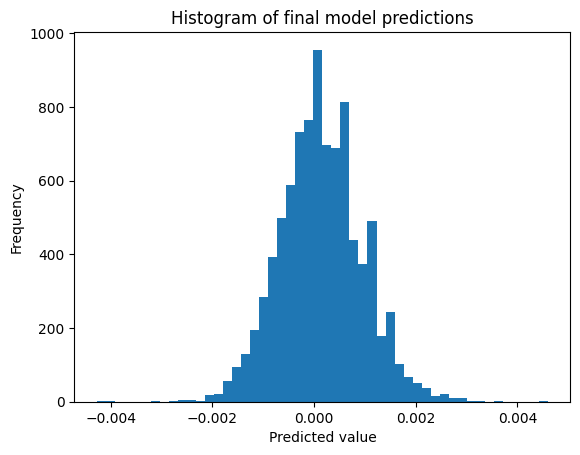

 10th percentile: -0.0009
 90th percentile: 0.0012
 99th percentile: 0.0022


In [153]:
display(pd.Series(preds).describe())
plt.hist(preds, bins=50)
plt.title("Histogram of final model predictions")
plt.xlabel("Predicted value")
plt.ylabel("Frequency")
plt.show()

print(f" 10th percentile: {np.percentile(preds, 10):.4f}")
print(f" 90th percentile: {np.percentile(preds, 90):.4f}")
print(f" 99th percentile: {np.percentile(preds, 99):.4f}")

In [159]:
import numpy as np
import pandas as pd
from scipy.stats import pearsonr
from xgboost import XGBRegressor

MIN_INVESTMENT = 0.0
MAX_INVESTMENT = 2.0
TRADING_DAYS_PER_YR = 252

# -----------------------------
# Baseline allocation: linear ramp with cap
# w_t = clip(yhat / scale, 0, 2), with scale calibrated from train preds
# -----------------------------
def alloc_on_off(yhat: np.ndarray, w_on: float = 1.0) -> np.ndarray:
    return np.where(yhat > 0, w_on, 0.0)

# -----------------------------
# Metric (matches your score() logic)
# -----------------------------
def adjusted_sharpe_metric(df: pd.DataFrame) -> dict:
    # df must have columns: position, forward_returns, risk_free_rate
    w = df["position"].values
    rf = df["risk_free_rate"].values
    r = df["forward_returns"].values

    strategy_returns = rf * (1 - w) + w * r
    strategy_excess = strategy_returns - rf

    # geometric mean daily excess return
    strat_excess_cum = np.prod(1.0 + strategy_excess)
    strat_mean_excess = strat_excess_cum ** (1.0 / len(df)) - 1.0

    strat_std = np.std(strategy_returns, ddof=1)
    if strat_std == 0:
        raise ValueError("Strategy std is zero -> Sharpe undefined")

    sharpe = (strat_mean_excess / strat_std) * np.sqrt(TRADING_DAYS_PER_YR)
    strat_vol = float(strat_std * np.sqrt(TRADING_DAYS_PER_YR) * 100.0)

    # market stats
    market_excess = r - rf
    market_excess_cum = np.prod(1.0 + market_excess)
    market_mean_excess = market_excess_cum ** (1.0 / len(df)) - 1.0

    market_std = np.std(r, ddof=1)
    if market_std == 0:
        raise ValueError("Market std is zero -> penalty undefined")

    market_vol = float(market_std * np.sqrt(TRADING_DAYS_PER_YR) * 100.0)

    # penalties
    excess_vol = max(0.0, strat_vol / market_vol - 1.2)
    vol_penalty = 1.0 + excess_vol

    return_gap = max(0.0, (market_mean_excess - strat_mean_excess) * 100.0 * TRADING_DAYS_PER_YR)
    return_penalty = 1.0 + (return_gap**2) / 100.0

    adjusted_sharpe = sharpe / (vol_penalty * return_penalty)

    return {
        "adjusted_sharpe": float(min(adjusted_sharpe, 1_000_000)),
        "sharpe": float(sharpe),
        "strategy_vol_pct": float(strat_vol),
        "market_vol_pct": float(market_vol),
        "vol_penalty": float(vol_penalty),
        "return_penalty": float(return_penalty),
        "strategy_mean_excess_daily_geo": float(strat_mean_excess),
        "market_mean_excess_daily_geo": float(market_mean_excess),
    }

# -----------------------------
# Rolling refit backtest
# - train on first half
# - then walk forward, refit every refit_every rows
# - predict next chunk, allocate positions, compute backtest stats
# -----------------------------
def rolling_backtest_baseline(
    full_train: pd.DataFrame,
    feature_cols: list[str],
    xgb_params: dict,
    half_life: float = 500.0,
    refit_every: int = 100,
    scale_quantile: float = 0.90,
):
    df = full_train.reset_index(drop=True).copy()
    n = len(df)

    # split: first half train only, second half is OOS simulation horizon
    split = n // 2
    oos_start = split

    # containers for OOS predictions + positions
    oos_pred = np.full(n, np.nan, dtype=float)
    oos_pos = np.full(n, np.nan, dtype=float)

    # walk-forward
    t = oos_start
    while t < n:
        # expanding train set up to t-1
        train_end = t  # exclusive
        X_train = df.loc[:train_end - 1, feature_cols]
        y_train = df.loc[:train_end - 1, "target"]

        # time-decay weights anchored at train_end-1 (local to this refit)
        idx = np.arange(train_end)
        age = (train_end - 1) - idx
        w_train = 0.5 ** (age / half_life)

        model = XGBRegressor(**xgb_params)
        model.fit(X_train, y_train, sample_weight=w_train, verbose=False)

        # predict next chunk
        chunk_end = min(t + refit_every, n)
        X_chunk = df.loc[t:chunk_end - 1, feature_cols]
        yhat_chunk = model.predict(X_chunk)

        # calibrate allocation scale from (in-sample) training predictions
        yhat_train = model.predict(X_train)
        pos_train = yhat_train[yhat_train > 0]
        scale = np.quantile(pos_train, scale_quantile) if len(pos_train) else 1.0
        if scale <= 0 or not np.isfinite(scale):
            scale = 1.0

        pos_chunk = alloc_on_off(yhat_chunk, w_on=1.0)

        # store
        oos_pred[t:chunk_end] = yhat_chunk
        oos_pos[t:chunk_end] = pos_chunk

        t = chunk_end

    # build OOS results frame (only second half)
    oos = df.loc[oos_start:].copy()
    oos["prediction"] = oos_pred[oos_start:]
    oos["position"] = oos_pos[oos_start:]

    # sanity: enforce bounds
    oos["position"] = oos["position"].clip(MIN_INVESTMENT, MAX_INVESTMENT)

    # compute backtest returns (same as score())
    oos["strategy_returns"] = oos["risk_free_rate"] * (1 - oos["position"]) + oos["position"] * oos["forward_returns"]
    oos["strategy_excess_returns"] = oos["strategy_returns"] - oos["risk_free_rate"]
    oos["market_excess_returns"] = oos["forward_returns"] - oos["risk_free_rate"]

    # IC diagnostics (prediction vs target on OOS)
    ic_pred_target = pearsonr(oos["prediction"].values, oos["target"].values)[0]

    # adjusted Sharpe metric + components
    metrics = adjusted_sharpe_metric(oos[["position", "forward_returns", "risk_free_rate"]].copy())
    metrics["oos_ic_pred_vs_target"] = float(ic_pred_target)

    return oos, metrics

# -----------------------------
# Example usage
# -----------------------------
final_features = sel_top_n_features(ranked_features, 15)

# IMPORTANT: ensure these exist on full_train
# - full_train["target"] already defined as next-day market_forward_excess_returns
# - full_train["forward_returns"], full_train["risk_free_rate"] exist
# - full_train is time-ordered

xgb_params = dict(
    objective="reg:squarederror",
    n_estimators=1500,
    learning_rate=0.005,
    max_depth=3,
    max_leaves=32,
    min_child_weight=2,
    gamma=0.0,
    reg_alpha=0.01,
    reg_lambda=0.5,
    subsample=0.1,
    colsample_bytree=0.5,
    colsample_bylevel=0.5,
    colsample_bynode=0.5,
    tree_method="hist",
    random_state=0,
)

oos_df, bt_metrics = rolling_backtest_baseline(
    full_train=full_train,
    feature_cols=final_features,
    xgb_params=xgb_params,
    half_life=500,
    refit_every=100,
    scale_quantile=0.90,   # tweak: 0.8/0.9/0.95
)

print("Backtest metrics:")
for k, v in bt_metrics.items():
    print(f"  {k}: {v}")

# oos_df now contains daily position + strategy_returns etc. for the OOS half
oos_df.head()


Backtest metrics:
  adjusted_sharpe: 0.5766457243048353
  sharpe: 0.5839793705346945
  strategy_vol_pct: 14.514187325661087
  market_vol_pct: 17.688609036349533
  vol_penalty: 1.0
  return_penalty: 1.012717767462336
  strategy_mean_excess_daily_geo: 0.00033634864993103974
  market_mean_excess_daily_geo: 0.0003810998719591119
  oos_ic_pred_vs_target: 0.020190794481045073


,date_id,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,forward_returns,risk_free_rate,market_forward_excess_returns,missing_indicator,target,prediction,position,strategy_returns,strategy_excess_returns,market_excess_returns
4494,4494,0,0,0,1,0,0,0,1,0,...,-0.006942,0.000153,-0.007407,1,0.009924,-0.000890,0.0,0.000153,0.000000,-0.007095
4495,4495,1,1,0,1,1,0,0,1,0,...,0.010388,0.000153,0.009924,1,-0.023870,0.000588,1.0,0.010388,0.010235,0.010235
4496,4496,0,0,0,1,1,0,0,1,0,...,-0.023408,0.000152,-0.023870,1,0.000668,-0.000306,0.0,0.000152,0.000000,-0.023559
4497,4497,0,0,0,1,1,0,1,0,1,...,0.001126,0.000147,0.000668,1,-0.008056,-0.000115,0.0,0.000147,0.000000,0.000979
4498,4498,0,0,0,1,1,0,0,0,1,...,-0.007606,0.000139,-0.008056,1,0.013007,0.000234,1.0,-0.007606,-0.007745,-0.007745


In [160]:
import numpy as np
import pandas as pd
from scipy.stats import pearsonr
from xgboost import XGBRegressor

MIN_INVESTMENT = 0.0
MAX_INVESTMENT = 2.0
TRADING_DAYS_PER_YR = 252

# -----------------------------
# Layer 1 allocation: thresholded on/off
# w_t = 1 if yhat > tau else 0
# -----------------------------
def alloc_threshold_on_off(yhat: np.ndarray, tau: float, w_on: float = 1.0) -> np.ndarray:
    return np.where(yhat > tau, w_on, 0.0)

# -----------------------------
# Metric (matches your score() logic)
# -----------------------------
def adjusted_sharpe_metric(df: pd.DataFrame) -> dict:
    w = df["position"].values
    rf = df["risk_free_rate"].values
    r = df["forward_returns"].values

    strategy_returns = rf * (1 - w) + w * r
    strategy_excess = strategy_returns - rf

    strat_excess_cum = np.prod(1.0 + strategy_excess)
    strat_mean_excess = strat_excess_cum ** (1.0 / len(df)) - 1.0

    strat_std = np.std(strategy_returns, ddof=1)
    if strat_std == 0:
        raise ValueError("Strategy std is zero -> Sharpe undefined")

    sharpe = (strat_mean_excess / strat_std) * np.sqrt(TRADING_DAYS_PER_YR)
    strat_vol = float(strat_std * np.sqrt(TRADING_DAYS_PER_YR) * 100.0)

    market_excess = r - rf
    market_excess_cum = np.prod(1.0 + market_excess)
    market_mean_excess = market_excess_cum ** (1.0 / len(df)) - 1.0

    market_std = np.std(r, ddof=1)
    if market_std == 0:
        raise ValueError("Market std is zero -> penalty undefined")

    market_vol = float(market_std * np.sqrt(TRADING_DAYS_PER_YR) * 100.0)

    excess_vol = max(0.0, strat_vol / market_vol - 1.2)
    vol_penalty = 1.0 + excess_vol

    return_gap = max(0.0, (market_mean_excess - strat_mean_excess) * 100.0 * TRADING_DAYS_PER_YR)
    return_penalty = 1.0 + (return_gap**2) / 100.0

    adjusted_sharpe = sharpe / (vol_penalty * return_penalty)

    return {
        "adjusted_sharpe": float(min(adjusted_sharpe, 1_000_000)),
        "sharpe": float(sharpe),
        "strategy_vol_pct": float(strat_vol),
        "market_vol_pct": float(market_vol),
        "vol_penalty": float(vol_penalty),
        "return_penalty": float(return_penalty),
        "strategy_mean_excess_daily_geo": float(strat_mean_excess),
        "market_mean_excess_daily_geo": float(market_mean_excess),
    }

# -----------------------------
# Rolling refit backtest (train on first half, refit every 100 rows)
# -----------------------------
def rolling_backtest_threshold_on_off(
    full_train: pd.DataFrame,
    feature_cols: list[str],
    xgb_params: dict,
    tau: float,                    # <-- TUNE THIS
    half_life: float = 500.0,
    refit_every: int = 100,
    w_on: float = 1.0,
):
    df = full_train.reset_index(drop=True).copy()
    n = len(df)

    split = n // 2
    oos_start = split

    oos_pred = np.full(n, np.nan, dtype=float)
    oos_pos  = np.full(n, np.nan, dtype=float)

    t = oos_start
    while t < n:
        train_end = t

        X_train = df.loc[:train_end - 1, feature_cols]
        y_train = df.loc[:train_end - 1, "target"]

        # fold-local time decay (anchored at train_end-1)
        idx = np.arange(train_end)
        age = (train_end - 1) - idx
        w_train = 0.5 ** (age / half_life)

        model = XGBRegressor(**xgb_params)
        model.fit(X_train, y_train, sample_weight=w_train, verbose=False)

        chunk_end = min(t + refit_every, n)
        X_chunk = df.loc[t:chunk_end - 1, feature_cols]
        yhat_chunk = model.predict(X_chunk)

        pos_chunk = alloc_threshold_on_off(yhat_chunk, tau=tau, w_on=w_on)

        oos_pred[t:chunk_end] = yhat_chunk
        oos_pos[t:chunk_end]  = pos_chunk

        t = chunk_end

    oos = df.loc[oos_start:].copy()
    oos["prediction"] = oos_pred[oos_start:]
    oos["position"]   = np.clip(oos_pos[oos_start:], MIN_INVESTMENT, MAX_INVESTMENT)

    oos["strategy_returns"] = (
        oos["risk_free_rate"] * (1 - oos["position"]) +
        oos["position"] * oos["forward_returns"]
    )

    oos["strategy_excess_returns"] = oos["strategy_returns"] - oos["risk_free_rate"]
    oos["market_excess_returns"] = oos["forward_returns"] - oos["risk_free_rate"]

    ic_pred_target = pearsonr(oos["prediction"].values, oos["target"].values)[0]

    metrics = adjusted_sharpe_metric(oos[["position", "forward_returns", "risk_free_rate"]].copy())
    metrics["oos_ic_pred_vs_target"] = float(ic_pred_target)

    return oos, metrics

# -----------------------------
# Example usage
# -----------------------------
final_features = sel_top_n_features(ranked_features, 15)

xgb_params = dict(
    objective="reg:squarederror",
    n_estimators=1500,
    learning_rate=0.005,
    max_depth=3,
    max_leaves=32,
    min_child_weight=2,
    gamma=0.0,
    reg_alpha=0.01,
    reg_lambda=0.5,
    subsample=0.1,
    colsample_bytree=0.5,
    colsample_bylevel=0.5,
    colsample_bynode=0.5,
    tree_method="hist",
    random_state=0,
)

tau = 0.0001  # <-- YOU TUNE THIS (try e.g. 0, 1e-5, 5e-5, 1e-4, 2e-4, ...)

oos_df, bt_metrics = rolling_backtest_threshold_on_off(
    full_train=full_train,
    feature_cols=final_features,
    xgb_params=xgb_params,
    tau=tau,
    half_life=500,
    refit_every=100,
    w_on=1.0,
)

print("Layer 1 (thresholded on/off) Backtest metrics:")
for k, v in bt_metrics.items():
    print(f"  {k}: {v}")


Layer 1 (thresholded on/off) Backtest metrics:
  adjusted_sharpe: 0.5860753919646481
  sharpe: 0.5941595315848734
  strategy_vol_pct: 14.186848998799197
  market_vol_pct: 17.688609036349533
  vol_penalty: 1.0
  return_penalty: 1.0137936854729996
  strategy_mean_excess_daily_geo: 0.0003344941093568199
  market_mean_excess_daily_geo: 0.0003810998719591119
  oos_ic_pred_vs_target: 0.020190794481045073


In [164]:
import numpy as np
import pandas as pd
from scipy.stats import pearsonr
from xgboost import XGBRegressor

MIN_INVESTMENT = 0.0
MAX_INVESTMENT = 2.0
TRADING_DAYS_PER_YR = 252

# -----------------------------
# Double piecewise linear allocation
# -----------------------------
def alloc_double_piecewise_linear(
    yhat: np.ndarray,
    tau1: float,
    tau2: float,
    tau3: float,
    w1: float = 1.0,
    w2: float = 2.0,
) -> np.ndarray:
    """
    Piecewise allocation:
    - 0                     if yhat <= tau1
    - linear 0 -> w1        if tau1 < yhat <= tau2
    - linear w1 -> w2       if tau2 < yhat <= tau3
    - w2                    if yhat > tau3
    """

    w = np.zeros_like(yhat, dtype=float)

    # Region 1: tau1 -> tau2
    mask1 = (yhat > tau1) & (yhat <= tau2)
    w[mask1] = w1 * (yhat[mask1] - tau1) / (tau2 - tau1)

    # Region 2: tau2 -> tau3
    mask2 = (yhat > tau2) & (yhat <= tau3)
    # w[mask2] = w1 + (w2 - w1) * (yhat[mask2] - tau2) / (tau3 - tau2)
    w[mask2] = w1

    # Region 3: saturation
    w[yhat > tau3] = w2

    return w


# -----------------------------
# Metric (matches competition score)
# -----------------------------
def adjusted_sharpe_metric(df: pd.DataFrame) -> dict:
    w = df["position"].values
    rf = df["risk_free_rate"].values
    r = df["forward_returns"].values

    strategy_returns = rf * (1 - w) + w * r
    strategy_excess = strategy_returns - rf

    strat_excess_cum = np.prod(1.0 + strategy_excess)
    strat_mean_excess = strat_excess_cum ** (1.0 / len(df)) - 1.0

    strat_std = np.std(strategy_returns, ddof=1)
    sharpe = strat_mean_excess / strat_std * np.sqrt(TRADING_DAYS_PER_YR)
    strat_vol = strat_std * np.sqrt(TRADING_DAYS_PER_YR) * 100.0

    market_excess = r - rf
    market_excess_cum = np.prod(1.0 + market_excess)
    market_mean_excess = market_excess_cum ** (1.0 / len(df)) - 1.0
    market_std = np.std(r, ddof=1)
    market_vol = market_std * np.sqrt(TRADING_DAYS_PER_YR) * 100.0

    vol_penalty = 1.0 + max(0.0, strat_vol / market_vol - 1.2)
    return_gap = max(0.0, (market_mean_excess - strat_mean_excess) * 100.0 * TRADING_DAYS_PER_YR)
    return_penalty = 1.0 + (return_gap ** 2) / 100.0

    adjusted_sharpe = sharpe / (vol_penalty * return_penalty)

    return {
        "adjusted_sharpe": float(adjusted_sharpe),
        "sharpe": float(sharpe),
        "strategy_vol_pct": float(strat_vol),
        "market_vol_pct": float(market_vol),
        "vol_penalty": float(vol_penalty),
        "return_penalty": float(return_penalty),
        "strategy_mean_excess_daily_geo": float(strat_mean_excess),
        "market_mean_excess_daily_geo": float(market_mean_excess),
    }


# -----------------------------
# Rolling refit backtest
# -----------------------------
def rolling_backtest_double_piecewise(
    full_train: pd.DataFrame,
    feature_cols: list[str],
    xgb_params: dict,
    tau1: float,
    tau2: float,
    tau3: float,
    half_life: float = 500.0,
    refit_every: int = 100,
):
    df = full_train.reset_index(drop=True).copy()
    n = len(df)

    split = n // 2
    oos_start = split

    oos_pred = np.full(n, np.nan)
    oos_pos = np.full(n, np.nan)

    t = oos_start
    while t < n:
        train_end = t

        X_train = df.loc[:train_end - 1, feature_cols]
        y_train = df.loc[:train_end - 1, "target"]

        idx = np.arange(train_end)
        age = (train_end - 1) - idx
        w_train = 0.5 ** (age / half_life)

        model = XGBRegressor(**xgb_params)
        model.fit(X_train, y_train, sample_weight=w_train, verbose=False)

        chunk_end = min(t + refit_every, n)
        X_chunk = df.loc[t:chunk_end - 1, feature_cols]
        yhat_chunk = model.predict(X_chunk)

        pos_chunk = alloc_double_piecewise_linear(
            yhat_chunk,
            tau1=tau1,
            tau2=tau2,
            tau3=tau3,
            w1=1.0,
            w2=1.25,
        )

        oos_pred[t:chunk_end] = yhat_chunk
        oos_pos[t:chunk_end] = pos_chunk
        t = chunk_end

    oos = df.loc[oos_start:].copy()
    oos["prediction"] = oos_pred[oos_start:]
    oos["position"] = np.clip(oos_pos[oos_start:], MIN_INVESTMENT, MAX_INVESTMENT)

    oos["strategy_returns"] = (
        oos["risk_free_rate"] * (1 - oos["position"])
        + oos["position"] * oos["forward_returns"]
    )

    ic = pearsonr(oos["prediction"], oos["target"])[0]
    metrics = adjusted_sharpe_metric(oos[["position", "forward_returns", "risk_free_rate"]])
    metrics["oos_ic_pred_vs_target"] = float(ic)

    return oos, metrics


# -----------------------------
# Example usage
# -----------------------------
final_features = sel_top_n_features(ranked_features, 15)

xgb_params = dict(
    objective="reg:squarederror",
    n_estimators=1500,
    learning_rate=0.005,
    max_depth=3,
    max_leaves=32,
    min_child_weight=2,
    gamma=0.0,
    reg_alpha=0.01,
    reg_lambda=0.5,
    subsample=0.1,
    colsample_bytree=0.5,
    colsample_bylevel=0.5,
    colsample_bynode=0.5,
    tree_method="hist",
    random_state=0,
)

# Sensible starting values from your prediction distribution
# tau1 = 0.0002  
# tau2 = 0.0005  
# tau3 = 1000000.02
tau1 = 0.00001  
tau2 = 0.0001  
tau3 = 0.003
  

oos_df, metrics = rolling_backtest_double_piecewise(
    full_train=full_train,
    feature_cols=final_features,
    xgb_params=xgb_params,
    tau1=tau1,
    tau2=tau2,
    tau3=tau3,
    half_life=500,
    refit_every=100,
)

print("Double piecewise linear allocation metrics:")
for k, v in metrics.items():
    print(f"  {k}: {v}")


Double piecewise linear allocation metrics:
  adjusted_sharpe: 0.548289251875198
  sharpe: 0.5575649160228275
  strategy_vol_pct: 14.891620658187293
  market_vol_pct: 17.688609036349533
  vol_penalty: 1.0
  return_penalty: 1.01691746485255
  strategy_mean_excess_daily_geo: 0.00032948592149706357
  market_mean_excess_daily_geo: 0.0003810998719591119
  oos_ic_pred_vs_target: 0.020190794481045073


In [166]:
X_final.columns

Index(['M4', 'S8', 'V13', 'V9', 'M12', 'S3', 'S1', 'I3', 'V5', 'P6', 'E19',
       'V10', 'M17', 'S5', 'P13'],
      dtype='object')